In [34]:
import tensorflow as tf

# Manually enable eager execution if it's not enabled
if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

# Check if eager execution is enabled
print("Is eager execution enabled?", tf.executing_eagerly())

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt

import skimage.data
import skimage.transform


from tensorflow.keras.optimizers import Adam
import random
import os


from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.misc
#import PIL
import matplotlib
import matplotlib.pyplot as plt
import skimage.data
import skimage.transform
import random
import os
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io


%matplotlib inline


Is eager execution enabled? True


In [35]:
print("Is eager execution enabled?", tf.executing_eagerly())

Is eager execution enabled? True


In [36]:
# Load testing datasets.
from google.colab import drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = '/content/gdrive/My Drive/DCML_CPS_2024'

data_root=root_path+'/Datasets/Traffic_Signs' #SHORTENED VERSION OF THE TESTING SET
test_data_dir=data_root+'/Testing/'

Mounted at /content/gdrive


In [37]:
#load data
def load_data(data_dir):
    """Loads a data set and returns two lists:
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels


In [38]:
#load the model
class TrafficSignNet:

	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (32, 32, 3)
		chanDim = -1
		# CONV => RELU => BN => POOL
		model.add(Conv2D(8, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
		model.add(Conv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# second set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model

In [39]:

aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
  validation_split=0.2,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")


# initialize the optimizer and compile the model
print("[INFO] compiling model...")
INIT_LR=0.001
NUM_EPOCHS=50
numLabels=62
BS=128
opt = Adam(learning_rate=INIT_LR, weight_decay=INIT_LR / (NUM_EPOCHS * 0.5))

model = TrafficSignNet.build(width=32, height=32, depth=3, classes=numLabels)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [40]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

cb=EarlyStopping(monitor='loss', mode='min', patience=3) # to stop after 3 times loss does not improve

checkpoint_path = root_path+"/TSC/checkpoint.weights.h5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_freq="epoch", #every epoch we save checkpoints
                                                 save_weights_only=True, verbose=1)

cb_list = [cb, cp_callback]

In [41]:
model.load_weights(root_path+"/TSC/checkpoint.weights.h5")  # SET PATH TO CHECKPOINT


In [42]:
t_images, t_labels = load_data(test_data_dir)

In [43]:
IMAGE_NUMBER=15
t_images[IMAGE_NUMBER].shape

(80, 60, 3)

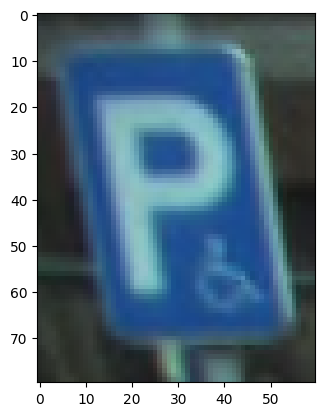

In [44]:
plt.figure()
plt.imshow(t_images[IMAGE_NUMBER])

In [45]:
# Transform the images, just like we did with the training set.
test_images = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in t_images]
#display_images_and_labels(test_images32, test_labels)
test_labels = np.array(t_labels) #TEST IMAGES
test_images = np.array(test_images) # LABELS

In [46]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │              

 Total params: 109,598 (428.12 KB)

 Trainable params: 108,878 (425.30 KB)

 Non-trainable params: 720 (2.81 KB)

In [47]:
loss, acc = model.evaluate(test_images, test_labels, verbose=2)

# Print the results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

4/4 - 4s - 1s/step - accuracy: 0.8611 - loss: 0.4218
Test Loss: 0.4218246340751648
Test Accuracy: 0.8611111044883728


**What to do next**

# Step 1: select a camera failure

For example: noise failure. Just select a failure you are confident with.

# Step 2: inject the failure on 10 test images

For example, create 10 "noisy" images. Repeat it for different configurations of the failure, e.g., different noise levels.

# Step 3: compute accuracy

Evaluate accuracy on the sets of 10 images. One computation of accuracy for each set. Can you see differences?


In [48]:
#get 10 random images

selected_indexes=np.random.choice(test_images.shape[0],size=10, replace=False)
images=test_images[selected_indexes]
images_labels=test_labels[selected_indexes]


An example of blur, how its impacing classifiers performance

In [49]:
import cv2
def apply_failure_blurred(input_images, parameters):
  #apply failure
  #write your code here to apply a failure to the input_images

  input_images = cv2.blur(input_images,(parameters,parameters)) #change values to increment/decrement blur. 0 is "no blur"

  return input_images




In [50]:
blur_level=15
failed_images=apply_failure_blurred(images[2], blur_level)
accuracy=model.evaluate(failed_images.reshape(1, 32,32,3), images_labels[2].reshape(1,))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.0000e+00 - loss: 6.2838


[6.283769130706787, 0.0]

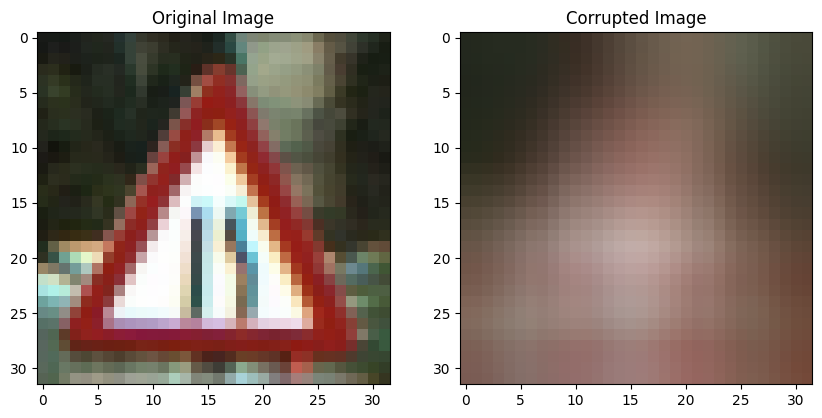

In [51]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[2])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(failed_images)
plt.title('Corrupted Image')
plt.show()

In [52]:
model.predict(failed_images.reshape(1, 32,32,3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


array([[1.0113891e-03, 5.2173581e-04, 9.8103832e-05, 1.1329548e-03,
        1.9631003e-05, 1.2303387e-05, 2.9306775e-06, 3.8966127e-06,
        5.1632691e-05, 4.2105758e-06, 3.7168409e-06, 1.3210098e-02,
        2.2908371e-05, 7.9233462e-01, 3.3635573e-04, 1.5019293e-05,
        1.8663526e-03, 1.8915067e-05, 5.1335614e-06, 4.9468823e-04,
        7.8177240e-05, 3.6730464e-05, 1.5953533e-01, 1.3799773e-05,
        2.3824980e-07, 3.4990103e-07, 5.2715006e-07, 1.8216588e-05,
        2.5369942e-02, 3.9596407e-04, 2.2316130e-05, 6.2221570e-06,
        1.5901636e-06, 2.6817854e-06, 2.6317606e-05, 2.7966587e-06,
        4.3215380e-07, 2.0689229e-06, 3.2066499e-05, 4.6705984e-05,
        3.0322638e-03, 1.6638989e-05, 1.4327423e-05, 6.6028852e-06,
        1.3380843e-06, 7.2436904e-07, 1.0458347e-06, 2.2691729e-06,
        2.4930225e-07, 3.3244845e-07, 3.0708418e-07, 2.4173494e-06,
        7.0601686e-06, 3.8910410e-05, 1.4809148e-05, 7.4836368e-07,
        1.7412369e-05, 1.4517116e-07, 3.2884222e

In [53]:
np.argmax(model.predict(failed_images.reshape(1, 32,32,3))),images_labels[2]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


(13, 16)

Now considering different levels of noise
how different level of noise can impact classifier performance

In [54]:
def apply_failure_noise(input_images, parameters):
  gauss = np.random.normal(0,parameters,images[2].size)
  gauss = gauss.reshape(input_images.shape[0],input_images.shape[1],input_images.shape[2]).astype('uint8')
  input_images = input_images + input_images * gauss
  return input_images


In [55]:
noiselevel=0.5 #different noise level e.g., 0.1, 02, 0.3
failed_images=apply_failure_noise(images[2], noiselevel)
accuracy=model.evaluate(failed_images.reshape(1, 32,32,3), images_labels[2].reshape(1,))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0000e+00 - loss: 526.4194


[526.41943359375, 0.0]

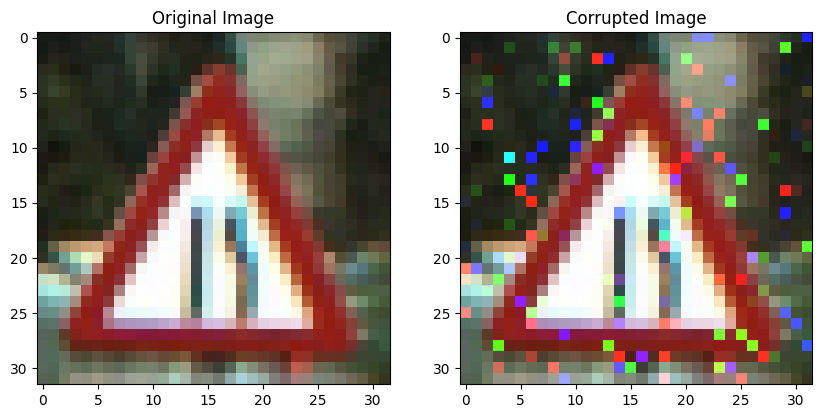

In [56]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[2])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(failed_images)
plt.title('Corrupted Image')
plt.show()

Here we simulate the impact of dead pixcels and check the performance of the
classifier

In [57]:
from random import randint
def apply_failure_deadpixcels(input_images, parameters):
    #input_images = cv2.cvtColor(input_images, cv2.COLOR_BGR2RGB)
    h, w, _ = input_images.shape
    input_images = input_images.copy()
    for z in range(0, num_of_Pixcels):  # You can adjust the number of noisy pixels by changing the range
        h1 = randint(1, h-1)
        w1 = randint(1, w-1)
        input_images[h1, w1] = (0, 0, 0)  # Set pixel to black
    return input_images



In [58]:
num_of_Pixcels = 200
failed_images=apply_failure_deadpixcels(images[2], num_of_Pixcels)
accuracy=model.evaluate(failed_images.reshape(1, 32,32,3), images_labels[2].reshape(1,))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0000e+00 - loss: 9.1414


[9.141386032104492, 0.0]

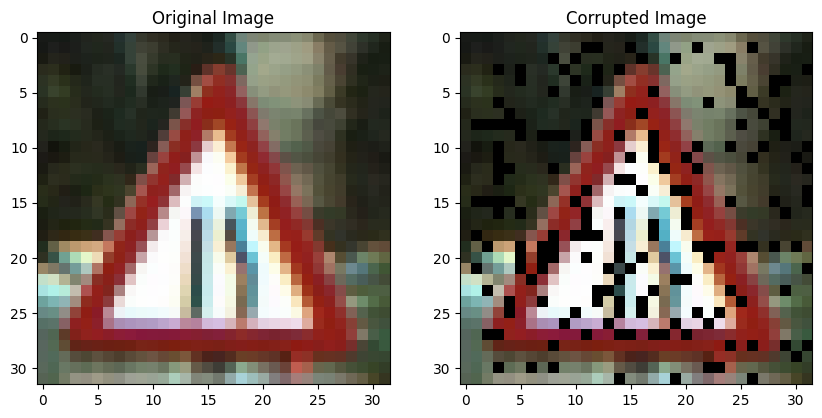

In [59]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[2])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(failed_images)
plt.title('Corrupted Image')
plt.show()

Impact of Brightness on classification
dark images or very bright images

In [60]:
from PIL import Image, ImageEnhance
import numpy as np

def apply_failure_Brightness(input_images, Brightnesslevel):
    if input_images.max() > 1:
        input_images = input_images / 255.0  # Normalize to [0, 1] if input is in range [0, 255]
    pil_image = Image.fromarray((input_images * 255).astype(np.uint8))
    enhancer = ImageEnhance.Brightness(pil_image)
    factor = Brightnesslevel
    pil_image = enhancer.enhance(factor)
    input_images = np.array(pil_image) / 255.0
    return input_images

In [61]:
Brightnesslevel = 0.3
failed_images=apply_failure_Brightness(images[2], Brightnesslevel)
accuracy=model.evaluate(failed_images.reshape(1, 32,32,3), images_labels[2].reshape(1,))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0000e+00 - loss: 1.7080


[1.708040475845337, 0.0]

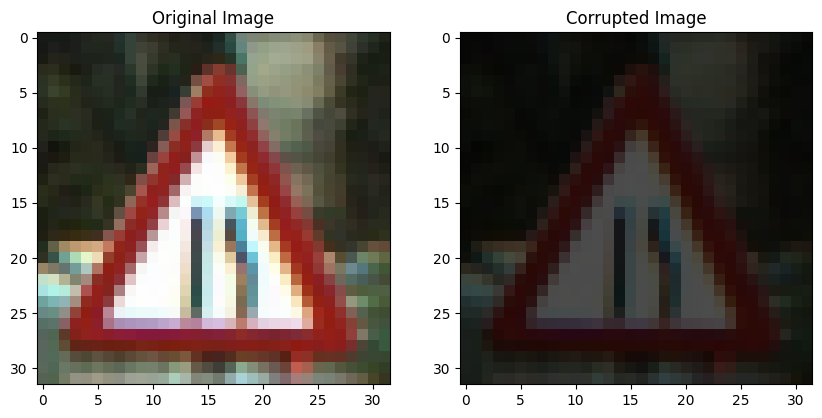

In [62]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[2])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(failed_images)
plt.title('Corrupted Image')
plt.show()

Rainy weather images creation

In [63]:
from PIL import Image
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

# Define paths
root_path = '/content/gdrive/My Drive/DCML_CPS_2024'
image_path = root_path + '/TSC/rain.png'

# Open the first image and convert it to RGBA
img2 = Image.open(image_path).convert("RGBA")
img1_array = np.array(images[2])
# Scale the values of img2_array if it is float64 and in the range [0, 1]
if img1_array.dtype == np.float64:
    img1_array = np.clip(img1_array * 255, 0, 255).astype(np.uint8)

# Convert img2_array back to a PIL Image
img1 = Image.fromarray(img1_array)

# Resize img1 to match the size of img2_pil
img1_resized = img1.resize(img2.size)

# Paste img1_resized into img2_pil (optional alpha channel handling)
img1_resized.paste(img2, (0, 0), img2)  # (0, 0) is the position to paste at

img3 = img1_resized.convert('RGB')

Mounted at /content/gdrive


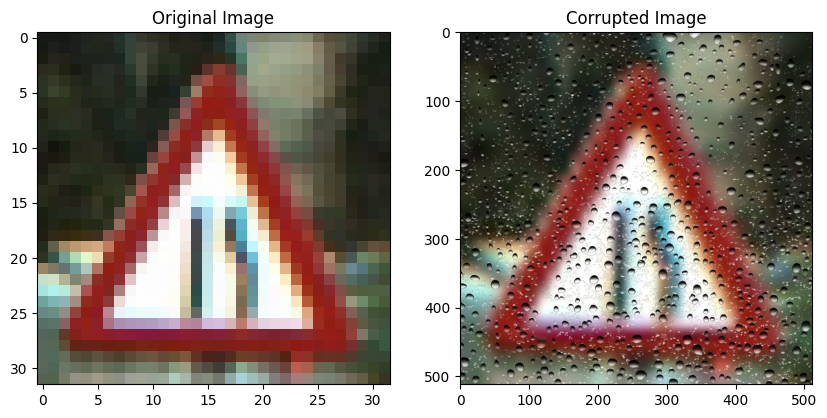

In [64]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[2])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(img3)
plt.title('Corrupted Image')
plt.show()

In [65]:
from PIL import Image
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

# Define paths
root_path = '/content/gdrive/My Drive/DCML_CPS_2024'
image_path = root_path + '/TSC/broken.png'

# Open the first image and convert it to RGBA
img2 = Image.open(image_path).convert("RGBA")

# Assuming images[2] is another image in your list, convert it to a NumPy array
img1_array = np.array(images[2])

# Scale the values of img1_array if it is float64 and in the range [0, 1]
if img1_array.dtype == np.float64:
    img1_array = np.clip(img1_array * 255, 0, 255).astype(np.uint8)

# Convert img1_array back to a PIL Image
img1 = Image.fromarray(img1_array)
img1_resized = img1.resize(img2.size)
# Manipulate pixels in img2 (example: set certain pixels to transparent)
pixels = img2.load()  # Load the pixel data of img2

# Iterate through each pixel in img2
for i in range(img2.size[0]):  # for every pixel width:
    for j in range(img2.size[1]):  # for every pixel height:
        if pixels[i, j][0] == 0 and pixels[i, j][3] > 100:  # If red channel is 0 and alpha is greater than 100
            # Set the pixel to transparent (RGBA with 0 alpha)
            pixels[i, j] = (pixels[i, j][0], pixels[i, j][0], pixels[i, j][0], 0)
# Paste img1_resized into img2 with the alpha channel handling
img1_resized.paste(img2, (0, 0), img2)  # (0, 0) is the position to paste at
img1_resized=img1_resized.resize((32,32))
# Convert the result to RGB (to remove alpha channel)
img3 = img1_resized.convert('RGB')



Mounted at /content/gdrive


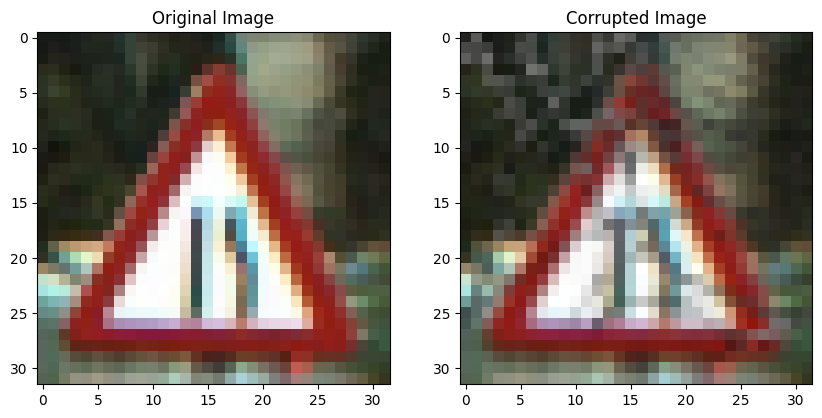

In [66]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[2])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(img3)
plt.title('Corrupted Image')
plt.show()